In [1]:
DATASET_NAME = "DSB2018" # DRIVE, CVC-ClinicDB, LUNGS2, ISIC2018, ISBI2012_EM, DSB2018
CFG_NAME = "Aug_Gauss_Unet"

In [2]:
# Import libraries

import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline
import numpy as np
import time
from tqdm import tqdm
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, ReduceLROnPlateau
from keras import callbacks
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from keras.preprocessing.image import ImageDataGenerator
from imgaug import augmenters as iaa
import models as M
import losses as l

ROOT_DIR = os.path.abspath("./")
DATASET_FOLDER = "npys"
DATASET_PATH = os.path.join(ROOT_DIR, "datasets", DATASET_FOLDER)
EXPERIMENT_NAME = "{}_{}".format(DATASET_NAME, CFG_NAME)

if not os.path.exists(os.path.join(ROOT_DIR, "logs")):
    os.mkdir(os.path.join(ROOT_DIR, "logs"))

LOG_PATH = os.path.join(ROOT_DIR, "logs", EXPERIMENT_NAME)

if not os.path.exists(LOG_PATH):
    os.mkdir(LOG_PATH)
    
print(os.listdir(DATASET_PATH))

train_data = np.load("{}/{}_images.npy".format(DATASET_PATH, DATASET_NAME)) 
train_labels = np.load("{}/{}_mask.npy".format(DATASET_PATH, DATASET_NAME))
print(train_data.shape, train_labels.shape)

Using TensorFlow backend.


['ISBI2012_EM_images.npy', 'CVC-ClinicDB_images.npy', 'CVC-ClinicDB_mask.npy', 'LUNGS2_images.npy', 'LUNGS2_mask.npy', 'DRIVE_images.npy', 'ISBI2012_EM_mask.npy', 'DSB2018_images.npy', 'ISIC2018_images.npy', 'DRIVE_mask.npy', 'DSB2018_mask.npy', 'ISIC2018_mask.npy']
(670, 256, 256, 3) (670, 256, 256, 1)


In [10]:
# standard augment 
seq_standard = iaa.Sequential([
    #iaa.Crop(px=(0, 16)), 
    iaa.Fliplr(0.5), 
    iaa.Affine(
        rotate=(-10, 10), # 25
    )
    #iaa.GaussianBlur(sigma=(0, 3.0))
], random_order=True)

# new augment
seq_custom = iaa.Sequential([
    iaa.ContrastNormalization((0.5, 1.5)),
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    iaa.Sometimes(0.7, 
        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5)
    ),
    iaa.Affine(
        rotate=(-25, 25),
    ),
    iaa.Affine(
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
    ),
    iaa.Affine(
        shear=(-25, 25)
    ),
    
    #iaa.Sometimes(0.8, 
     #   iaa.CoarseDropout(0.03, size_percent=0.1)
    #),
], random_order=True) # apply augmenters in random order


def augment_data_minimal( x_values, y_values ):
    counter = 0
    RESIZE_DIM = x_values.shape[1]
    RESIZE_DIM_ = x_values.shape[2]
    channels = x_values.shape[-1]
    X_values_augmented = []
    Y_values_augmented = []
    for x,y in zip(x_values, y_values):
        for p in range(3):
            
            # seq 1
            images_aug = seq_standard.augment_images(x.reshape(1,RESIZE_DIM,RESIZE_DIM_,channels))
            masks_aug = seq_standard.augment_images(y.reshape(1,RESIZE_DIM,RESIZE_DIM_,1))
            X_values_augmented.append( images_aug.reshape(RESIZE_DIM,RESIZE_DIM_,channels))
            Y_values_augmented.append( masks_aug.reshape(RESIZE_DIM,RESIZE_DIM_,1))
            
            # seq 2
            #Y_values_augmented.append( y_values[counter] )
            #images_aug = seq_custom.augment_images(x.reshape(1,RESIZE_DIM,RESIZE_DIM,3))   
            #X_values_augmented.append( images_aug.reshape(RESIZE_DIM,RESIZE_DIM,3))

        counter = counter + 1
    
    
    # prev number of images = n
    # augmented number of images = n * 4 ( 2 seq 2 times)
    X_values_augmented = np.asarray( X_values_augmented )
    Y_values_augmented = np.asarray( Y_values_augmented )
    return (X_values_augmented, Y_values_augmented)



# Runtime data augmentation
def get_train_test_augmented(X_train, Y_train, X_test, Y_test, batch_size=16, seed=42):
   
    # Image data generator distortion options
    data_gen_args = dict(featurewise_center = False, 
                         samplewise_center = False,
                         rotation_range=5.,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         shear_range=0.2,
                         zoom_range=0.2,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode='constant')
    
    
    data_gen_args2 = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 5, 
                  width_shift_range = 0.01, 
                  height_shift_range = 0.01, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.1],  
                  horizontal_flip = True, 
                  vertical_flip = True, # no upside down cars
                  fill_mode = 'nearest',
                  data_format = 'channels_last')
    

    # Train data, provide the same seed and keyword arguments to the fit and flow methods
    X_datagen = ImageDataGenerator(**data_gen_args)
    Y_datagen = ImageDataGenerator(**data_gen_args)
    X_datagen.fit(X_train, augment=True, seed=seed)
    Y_datagen.fit(Y_train, augment=True, seed=seed)
    X_train_augmented = X_datagen.flow(X_train, batch_size=batch_size, shuffle=True, seed=seed)
    Y_train_augmented = Y_datagen.flow(Y_train, batch_size=batch_size, shuffle=True, seed=seed)
     
    
    # Test data, no data augmentation, but we create a generator anyway
    X_datagen_val = ImageDataGenerator()
    Y_datagen_val = ImageDataGenerator()
    X_datagen_val.fit(X_test, augment=True, seed=seed)
    Y_datagen_val.fit(Y_test, augment=True, seed=seed)
    X_test_augmented = X_datagen_val.flow(X_test, batch_size=batch_size, shuffle=True, seed=seed)
    Y_test_augmented = Y_datagen_val.flow(Y_test, batch_size=batch_size, shuffle=True, seed=seed)
    
    
    # combine generators into one which yields image and masks
    train_generator = zip(X_train_augmented, Y_train_augmented)
    test_generator = zip(X_test_augmented, Y_test_augmented)
    
    return train_generator, test_generator

In [11]:
#(x_aug, y_aug) = augment_data_minimal( train_data, train_labels)
#x_aug.shape, y_aug.shape

In [12]:
#X_train_augmented = np.concatenate( (train_data, x_aug), axis = 0)
#Y_train_augmented = np.concatenate( (train_labels, y_aug), axis = 0)
#X_train_augmented.shape, Y_train_augmented.shape

In [13]:
#import random 
#plt.figure(figsize=(20,20))
#columns = 5
#lower = 0
#upper = 10 
#for i in range(upper):
#    ax = plt.subplot(upper / columns + 1, columns, i + 1)
#    idx = random.randint(0, len(x_aug))
#    #ax.set_title(y_aug[idx])
#    plt.grid(False)
#    plt.imshow(np.squeeze(x_aug[idx]), cmap='gray') # binary
#
#plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [14]:
# Plot and save accuravy loss graphs individually
def plot_loss_accu(history):
    loss = history.history['loss'][1:]
    val_loss = history.history['val_loss'][1:]
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'g')
    plt.plot(epochs, val_loss, 'y')
    plt.title('Training and validation loss')
    plt.ylabel('Loss %')
    plt.xlabel('Epoch')
    plt.legend(['training', 'validation'], loc='upper right')
    plt.grid(True)
    #plt.savefig('{}/{}_loss.jpg'.format(output_path, EXP_NAME), dpi=100)
    plt.savefig('{}/{}_loss_graph.pdf'.format(LOG_PATH, EXPERIMENT_NAME), dpi=100)
    plt.show()
    
    loss = history.history['jacard'][1:]
    val_loss = history.history['val_jacard'][1:]
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'r')
    plt.plot(epochs, val_loss, 'b')
    plt.title('Training and validation jaccard index')
    plt.ylabel('Accuracy %')
    #plt.xlabel('Epoch')
    plt.legend(['training', 'validation'], loc='lower right')
    plt.grid(True)
    #plt.savefig('{}/{}_acc.jpg'.format(output_path, EXP_NAME), dpi=100)
    plt.savefig('{}/{}_jac_graph.pdf'.format(LOG_PATH, EXPERIMENT_NAME), dpi=100)
    plt.show()

In [15]:
# Build model
#model = M.g_unet(input_size = (train_data.shape[1], train_data.shape[2], train_data.shape[-1]))
#model.summary()

In [16]:
# Callbacks
weights_path = "{}/{}.h5".format(LOG_PATH, EXPERIMENT_NAME)
checkpointer = ModelCheckpoint(filepath=weights_path, verbose=0, monitor='val_jacard', mode='max', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_jacard', factor=0.1, patience=10, verbose=1, min_lr=1e-8, mode='max') # new_lr = lr * factor
early_stopping = EarlyStopping(monitor='val_jacard', min_delta=0, verbose=1, patience=20, mode='max', restore_best_weights=True)
csv_logger = CSVLogger('{}/{}_training.csv'.format(LOG_PATH, EXPERIMENT_NAME))

Fold 0 train on ------->  (536, 256, 256, 3) (134, 256, 256, 3) (536, 256, 256, 1) (134, 256, 256, 1)
Epoch 1/100000
17/16 [==============================] - 6s 347ms/step - loss: 1.2161 - jacard: 0.0988 - dice_coef: 0.1769 - val_loss: 0.6087 - val_jacard: 0.0971 - val_dice_coef: 0.1764
Epoch 2/100000
17/16 [==============================] - 4s 250ms/step - loss: 0.6249 - jacard: 0.1114 - dice_coef: 0.1993 - val_loss: 0.5226 - val_jacard: 0.1462 - val_dice_coef: 0.2536
Epoch 3/100000
17/16 [==============================] - 2s 145ms/step - loss: 0.4564 - jacard: 0.1549 - dice_coef: 0.2635 - val_loss: 0.2431 - val_jacard: 0.2353 - val_dice_coef: 0.3795
Epoch 4/100000
17/16 [==============================] - 2s 146ms/step - loss: 0.2762 - jacard: 0.2404 - dice_coef: 0.3831 - val_loss: 0.2413 - val_jacard: 0.2695 - val_dice_coef: 0.4209
Epoch 5/100000
17/16 [==============================] - 3s 149ms/step - loss: 0.2640 - jacard: 0.2603 - dice_coef: 0.4106 - val_loss: 0.2208 - val_jacard:

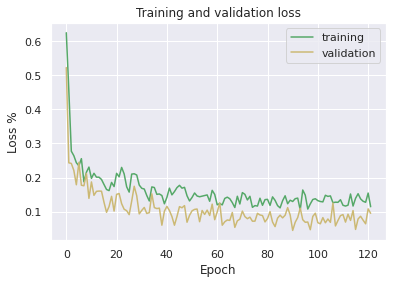

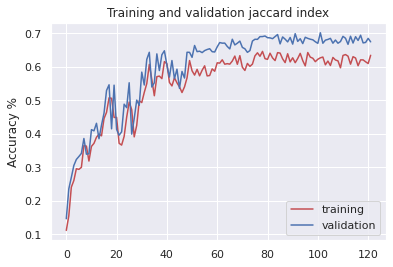

Fold 1 train on ------->  (536, 256, 256, 3) (134, 256, 256, 3) (536, 256, 256, 1) (134, 256, 256, 1)
Epoch 1/100000
17/16 [==============================] - 3s 187ms/step - loss: 0.7988 - jacard: 0.1063 - dice_coef: 0.1887 - val_loss: 0.6221 - val_jacard: 0.1665 - val_dice_coef: 0.2850
Epoch 2/100000
17/16 [==============================] - 2s 139ms/step - loss: 0.5787 - jacard: 0.1230 - dice_coef: 0.2178 - val_loss: 0.4484 - val_jacard: 0.1583 - val_dice_coef: 0.2722
Epoch 3/100000
17/16 [==============================] - 2s 142ms/step - loss: 0.6832 - jacard: 0.1157 - dice_coef: 0.2054 - val_loss: 0.4662 - val_jacard: 0.1222 - val_dice_coef: 0.2171
Epoch 4/100000
17/16 [==============================] - 2s 139ms/step - loss: 0.5623 - jacard: 0.1093 - dice_coef: 0.1958 - val_loss: 0.5874 - val_jacard: 0.1529 - val_dice_coef: 0.2640
Epoch 5/100000
17/16 [==============================] - 2s 142ms/step - loss: 0.4826 - jacard: 0.1469 - dice_coef: 0.2550 - val_loss: 0.4745 - val_jacard:

In [ ]:
# Store results from multiple runs
jacs = []
dices = []
all_epochs = []
losses = []

best_jac = 0

# Calculate the starting time    
start_time = time.time()

for i in range(5):
    
    # Split the data
    #x_train, x_test, y_train, y_test = train_test_split(train_data, train_labels, shuffle=True, test_size=0.20, random_state=42)
    indices=list(range(len(train_data)))
    np.random.shuffle(indices)
    ind=int(len(indices)*0.80)
    train = indices[:ind]
    test = indices[-(len(indices)-ind):]

    x_train = train_data[train]
    x_test = train_data[test]
    y_train = train_labels[train]
    y_test = train_labels[test]
    
    # Augment data
    #(x_aug, y_aug) = augment_data_minimal( x_train, y_train)    
    # Upsample data
    #x_train = np.concatenate( (x_train, x_aug), axis = 0)
    #y_train = np.concatenate( (y_train, y_aug), axis = 0)    
    

    print("Fold {} train on -------> ".format(i), x_train.shape, x_test.shape, y_train.shape, y_test.shape)
    
    # Clearing the NN.
    K.clear_session()
    model = None 
    
    # Define the model
    model = M.unet(input_size = (train_data.shape[1], train_data.shape[2], train_data.shape[-1]))
    
    # Train
    batch_size = 16 
    epochs = 100000
    
    
    
    # Data genenrators
    train_generator, test_generator = get_train_test_augmented(x_train, y_train, x_test,
                                                               y_test, batch_size=batch_size, seed=42)
    model.fit_generator(train_generator, validation_data=test_generator, validation_steps=batch_size/2,
                        steps_per_epoch=len(x_train)/(batch_size * 2), epochs=epochs,
                        callbacks=[early_stopping, reduce_lr],
                        shuffle=True)
    
    
   # model.fit(x_train, y_train,
   #                 batch_size=batch_size,
   #                 epochs=epochs,
   #                 validation_data=(x_test, y_test),
   #                 callbacks=[early_stopping, reduce_lr],
   #                 shuffle=True)
    
    
    # Log number of epochs to train and minimum loss
    total_epochs = len(model.history.history['loss'])
    min_loss = min(model.history.history['val_loss'])
    all_epochs.append(total_epochs)
    losses.append(min_loss)

    
    
    
    # Evaluate trained model using Jaccard and Dice metric
    yp = None
    yp = model.predict(x=x_test, batch_size=batch_size, verbose=0)
    yp = np.round(yp,0)

    jacard = 0
    dice = 0
    
    for i in range(len(y_test)):
        yp_2 = yp[i].ravel()
        y2 = y_test[i].ravel()

        intersection = yp_2 * y2
        union = yp_2 + y2 - intersection

        jacard += (np.sum(intersection)/np.sum(union))  
        dice += (2. * np.sum(intersection) ) / (np.sum(yp_2) + np.sum(y2))

    jacard /= len(y_test)
    dice /= len(y_test)

    print('Jacard Index : '+str(jacard))
    print('Dice Coefficient : '+str(dice))
    
    jacs.append(jacard)
    dices.append(dice)
    
    #best_jac = max(jacs)
    
    if jacard > best_jac:
        
        print('***********************************************')
        print('Jacard Index improved from '+str(best_jac)+' to '+str(jacard))
        print('***********************************************')
        # Save model
        model.save(weights_path)
        
        # Save loss
        loss_history = model.history.history["val_loss"]
        loss_history = np.array(loss_history)
        np.savetxt("{}/{}_loss.txt".format(LOG_PATH, EXPERIMENT_NAME), loss_history, delimiter=",")
        
        # Save jaccard
        jacard_history = model.history.history["val_jacard"]
        jacard_history = np.array(jacard_history)
        np.savetxt("{}/{}_jacard.txt".format(LOG_PATH, EXPERIMENT_NAME), jacard_history, delimiter=",")
        
        # Save images, masks, and predicted masks
        np.save("{}/{}_inputs.npy".format(LOG_PATH, EXPERIMENT_NAME), x_test)
        np.save("{}/{}_masks.npy".format(LOG_PATH, EXPERIMENT_NAME), y_test)
        np.save("{}/{}_predicted_masks.npy".format(LOG_PATH, EXPERIMENT_NAME), yp)
        
        # Log training history
        plot_loss_accu(model.history)
        
        final_images = x_test
        final_masks = y_test
        final_preds = yp
        
        best_jac = jacard


end_time = time.time()
print("--- Time taken to train : %s hours ---" % ((end_time - start_time)//3600))

In [15]:
jacs = [x * 100 for x in jacs]
dices = [x * 100 for x in dices]

In [16]:
jacs, dices

([77.22905476888022,
  77.06298828125,
  77.06298828125,
  78.1402587890625,
  78.1402587890625],
 [87.1379202022991,
  87.03626698789172,
  87.03626698789172,
  87.71131506409041,
  87.71131506409041])

In [17]:
print("Jaccard: %.4f%% (+/- %.4f%%)" % (np.mean(jacs), np.std(jacs)))
print("Dice: %.4f%% (+/- %.4f%%)" % (np.mean(dices), np.std(dices)))
print("Epochs: %.4f%% (+/- %.4f%%)" % (np.mean(all_epochs), np.std(all_epochs)))
print("Loss: %.4f%% (+/- %.4f%%)" % (np.mean(losses), np.std(losses)))

Jaccard: 77.5271% (+/- 0.5043%)
Dice: 87.3266% (+/- 0.3163%)
Epochs: 25.6000% (+/- 0.4899%)
Loss: 0.4933% (+/- 0.0095%)


In [18]:
# Store report

report = {}

report['Mean Jaccard + Std = '] = ("%.4f%% +/- %.4f%%" % (np.mean(jacs), np.std(jacs)))
report['Mean Dice + Std = '] = ("%.4f%% +/- %.4f%%" % (np.mean(dices), np.std(dices)))
report['Mean Epoch + Std = '] = ("%.4f%% +/- %.4f%%" % (np.mean(all_epochs), np.std(all_epochs)))
report['Mean Loss + Std = '] = ("%.4f%% +/- %.4f%%" % (np.mean(losses), np.std(losses)))

with open("{}/{}_REPORT.txt".format(LOG_PATH, EXPERIMENT_NAME), 'w') as f:
    for k,v in report.items():
        f.write(str(k))
        #f.write("--->")
        f.write(str(v))
        
        # new line
        f.write("\n")

f.close()

In [ ]:
l = loss_history
j = jacard_history
epochs = range(len(j))
plt.plot(epochs, l, 'g')
plt.plot(epochs, j, 'y')

In [ ]:
x_test = final_images
y_test = final_masks
yp = final_preds

In [ ]:
try:
    os.makedirs('{}/results/'.format(LOG_PATH, EXPERIMENT_NAME))
except:
    pass 

for i in range(5):
    
    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1)
    if len(x_test[i].shape) >= 2:
        plt.grid(False)
        plt.imshow(x_test[i].squeeze(), cmap='gray') # 1-channel image
    else:
        plt.grid(False)
        plt.imshow(x_test[i]) # 3-channel
        
    plt.title('Input')
    plt.subplot(1,3,2)
    plt.grid(False)
    plt.imshow(y_test[i].reshape(y_test[i].shape[0],y_test[i].shape[1]), cmap='magma')
    plt.title('Ground Truth')
    plt.subplot(1,3,3)
    plt.grid(False)
    plt.imshow(yp[i].reshape(yp[i].shape[0],yp[i].shape[1]), cmap='magma')
    plt.title('Prediction')
    
    # Calc jaccard index of predictions
    intersection = yp[i].ravel() * y_test[i].ravel()
    union = yp[i].ravel() + y_test[i].ravel() - intersection
    jacard = (np.sum(intersection)/np.sum(union))  
    
    plt.suptitle('Jacard Index: '+ str(np.sum(intersection)) +'/'+ str(np.sum(union)) +' = '+str(jacard))
    plt.savefig('{}/results/'.format(LOG_PATH, EXPERIMENT_NAME)+str(i)+'.png',format='png')
    plt.show()
    plt.close()